In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content
!ln -s "/content/drive/MyDrive/Colab Notebooks/AIBook" /googledrive





Mounted at /content/drive
/content


In [2]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


In [3]:
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2
import pandas as pd



from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display


model = load_model('/googledrive/YogaNet_model_2_1.h5')

1/1 [==============================] - 0s 19ms/step
[0. 0. 0. 0. 1.]


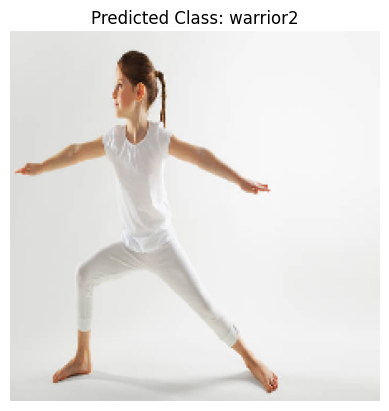

In [31]:

img = load_img('/googledrive/target.jpg', target_size=(224, 224))
x = img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

array = classes.flatten()

def find_max_index(arr):
    max_val = arr[0]
    max_index = 0

    for i in range(1, len(arr)):
        if arr[i] > max_val:
            max_val = arr[i]
            max_index = i

    return max_index

# 找到最大值的索引
index = find_max_index(array)



print(array)


if index == 0:
      pose_name ='downdog'
elif index == 1:
      pose_name ='goddess'
elif index == 2:
      pose_name ='plank'
elif index == 3:
      pose_name ='tree'
else:
      pose_name ='warrior2'


# 視覺化圖片
plt.imshow(img)
plt.axis('off')  # 不顯示坐標軸
plt.title('Predicted Class: {}'.format(pose_name))
plt.show()





In [32]:
model_name = "movenet_lightning"

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
    input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  elif "movenet_thunder_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoint_with_scores = outputs['output_0'].numpy()
    return keypoint_with_scores

In [33]:
def draw_prediction_on_image(
     image, keypoints_with_scores, crop_region=None, close_figure=False,
     output_image_height=None):
   """Draws the keypoint predictions on image"""
   height, width, channel = image.shape
   aspect_ratio = float(width) / height
   fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
   # To remove the huge white borders
   fig.tight_layout(pad=0)
   ax.margins(0)
   ax.set_yticklabels([])
   ax.set_xticklabels([])
   plt.axis('off')
   im = ax.imshow(image)
   line_segments = LineCollection([], linewidths=(4), linestyle='solid')
   ax.add_collection(line_segments)
   # Turn off tick labels
   scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)
   (keypoint_locs, keypoint_edges,
    edge_colors) = _keypoints_and_edges_for_display(
        keypoints_with_scores, height, width)
   line_segments.set_segments(keypoint_edges)
   line_segments.set_color(edge_colors)
   if keypoint_edges.shape[0]:
     line_segments.set_segments(keypoint_edges)
     line_segments.set_color(edge_colors)
   if keypoint_locs.shape[0]:
     scat.set_offsets(keypoint_locs)
   if crop_region is not None:
     xmin = max(crop_region['x_min'] * width, 0.0)
     ymin = max(crop_region['y_min'] * height, 0.0)
     rec_width = min(crop_region['x_max'], 0.99) * width - xmin
     rec_height = min(crop_region['y_max'], 0.99) * height - ymin
     rect = patches.Rectangle(
         (xmin,ymin),rec_width,rec_height,
         linewidth=1,edgecolor='b',facecolor='none')
     ax.add_patch(rect)
   fig.canvas.draw()
   image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
   image_from_plot = image_from_plot.reshape(
       fig.canvas.get_width_height()[::-1] + (3,))
   plt.close(fig)
   if output_image_height is not None:
     output_image_width = int(output_image_height / height * width)
     image_from_plot = cv2.resize(
         image_from_plot, dsize=(output_image_width, output_image_height),
          interpolation=cv2.INTER_CUBIC)
   return image_from_plot

In [34]:
def _keypoints_and_edges_for_display(keypoints_with_score,height,
                                      width,keypoint_threshold=0.11):
   """Returns high confidence keypoints and edges"""
   keypoints_all = []
   keypoint_edges_all = []
   edge_colors = []
   num_instances,_,_,_ = keypoints_with_score.shape
   for id in range(num_instances):
     kpts_x = keypoints_with_score[0,id,:,1]
     kpts_y = keypoints_with_score[0,id,:,0]
     kpts_scores = keypoints_with_score[0,id,:,2]
     kpts_abs_xy = np.stack(
         [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
     kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
     keypoints_all.append(kpts_above_thrs_abs)
     for edge_pair,color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
       if (kpts_scores[edge_pair[0]] > keypoint_threshold and
           kpts_scores[edge_pair[1]] > keypoint_threshold):
         x_start = kpts_abs_xy[edge_pair[0],0]
         y_start = kpts_abs_xy[edge_pair[0],1]
         x_end = kpts_abs_xy[edge_pair[1],0]
         y_end = kpts_abs_xy[edge_pair[1],1]
         lien_seg = np.array([[x_start,y_start],[x_end,y_end]])
         keypoint_edges_all.append(lien_seg)
         edge_colors.append(color)
   if keypoints_all:
     keypoints_xy = np.concatenate(keypoints_all,axis=0)
   else:
     keypoints_xy = np.zeros((0,17,2))
   if keypoint_edges_all:
     edges_xy = np.stack(keypoint_edges_all,axis=0)
   else:
     edges_xy = np.zeros((0,2,2))
   return keypoints_xy,edges_xy,edge_colors

In [35]:
# Dictionary to map joints of body part
KEYPOINT_DICT = {
     'nose':0,
     'left_eye':1,
     'right_eye':2,
     'left_ear':3,
     'right_ear':4,
     'left_shoulder':5,
     'right_shoulder':6,
     'left_elbow':7,
     'right_elbow':8,
     'left_wrist':9,
     'right_wrist':10,
     'left_hip':11,
     'right_hip':12,
     'left_knee':13,
     'right_knee':14,
     'left_ankle':15,
     'right_ankle':16
 }

In [36]:
# map bones to matplotlib color name
KEYPOINT_EDGE_INDS_TO_COLOR = {
     (0,1): 'm',
     (0,2): 'c',
     (1,3): 'm',
     (2,4): 'c',
     (0,5): 'm',
     (0,6): 'c',
     (5,7): 'm',
     (7,9): 'm',
     (6,8): 'c',
     (8,10): 'c',
     (5,6): 'y',
     (5,11): 'm',
     (6,12): 'c',
     (11,12): 'y',
     (11,13): 'm',
     (13,15): 'm',
     (12,14): 'c',
     (14,16): 'c'
 }

In [37]:

target_dir =  r'/googledrive/target.jpg'
# Load the input image.
image_path = target_dir
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)

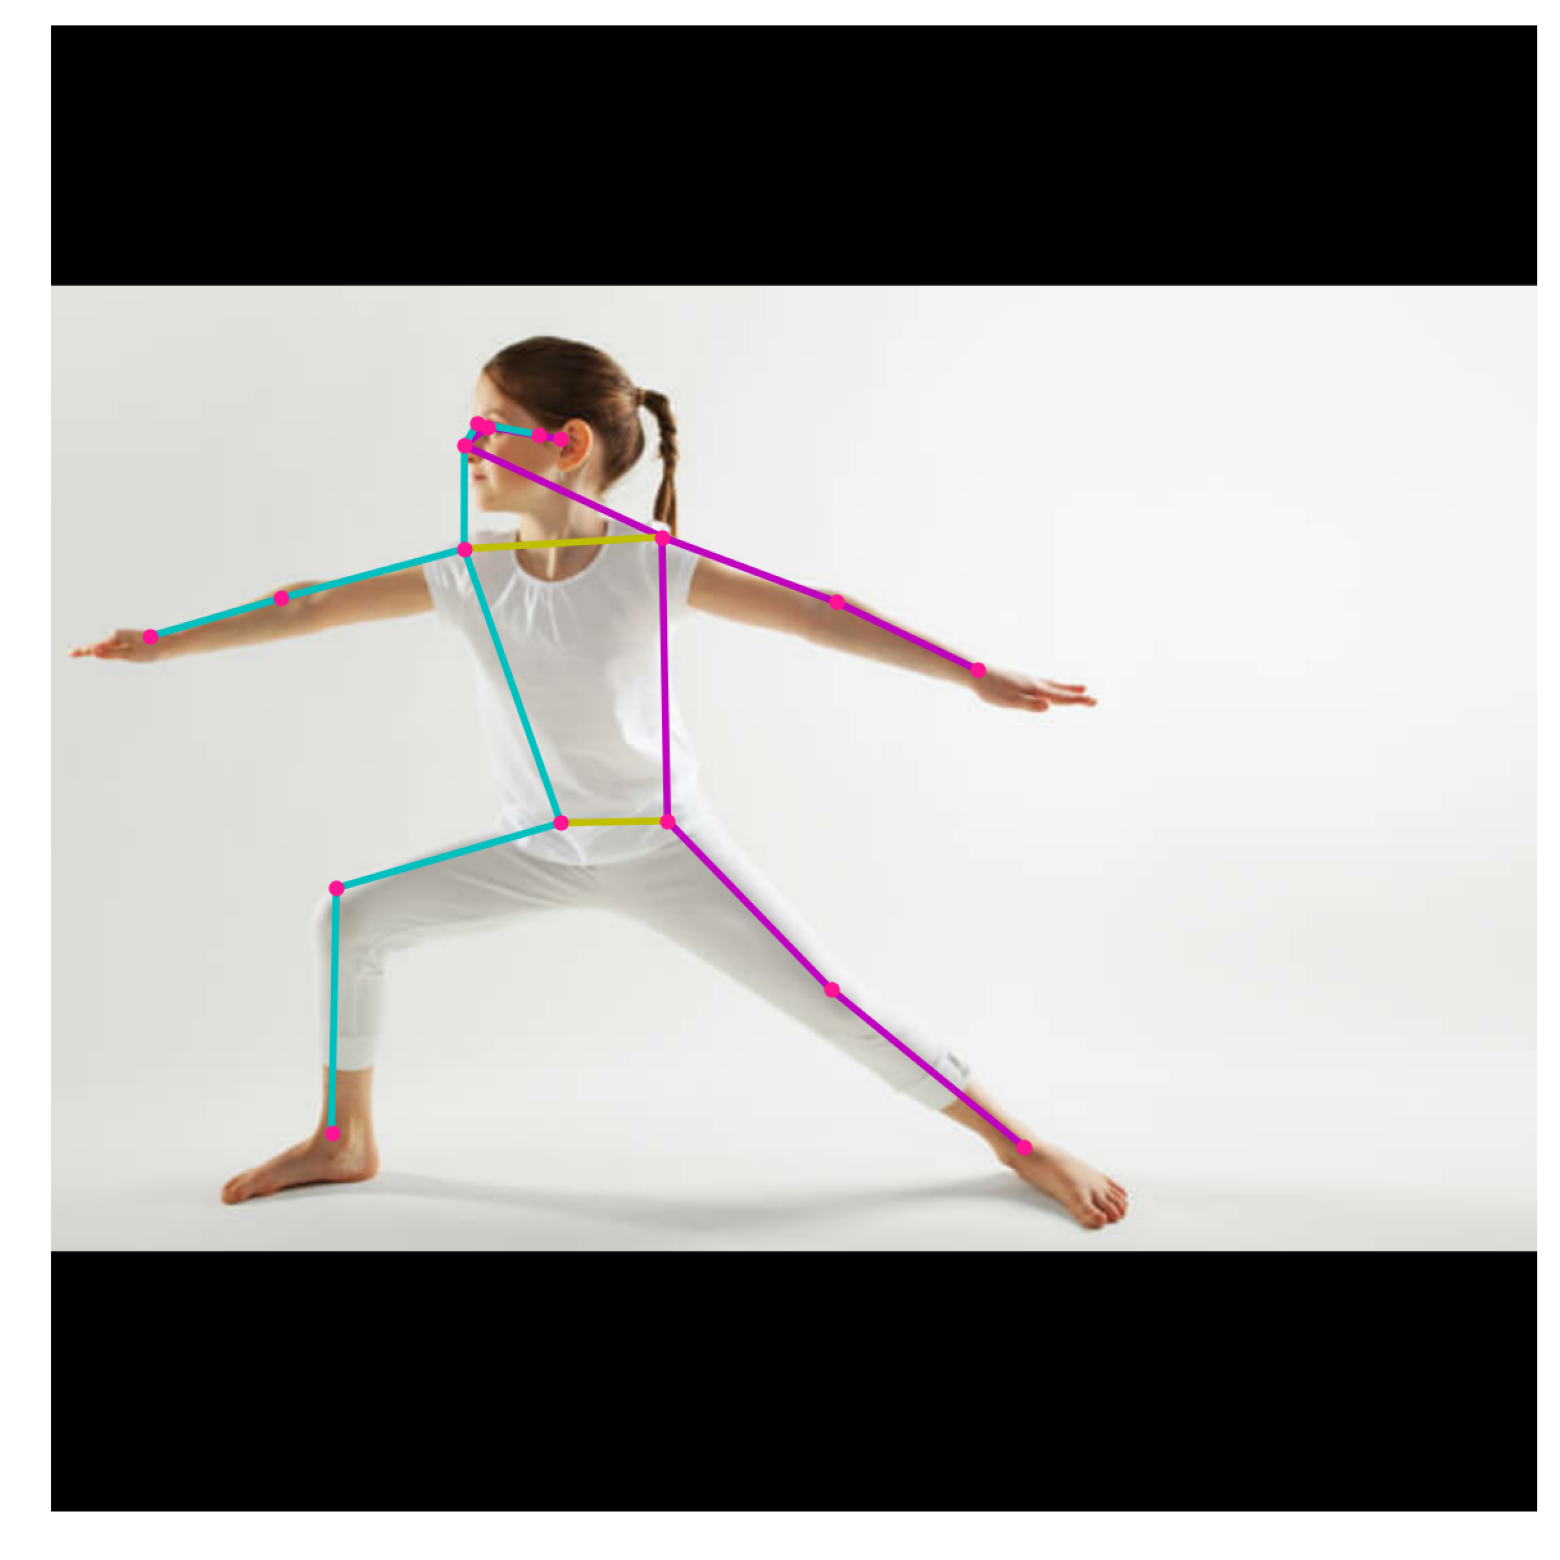

In [38]:
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoint_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)

plt.figure(figsize=(20, 20))
plt.imshow(output_overlay)
_ = plt.axis('off')

In [39]:
target_keypoint=keypoint_with_scores

標準的warrior2姿勢為:


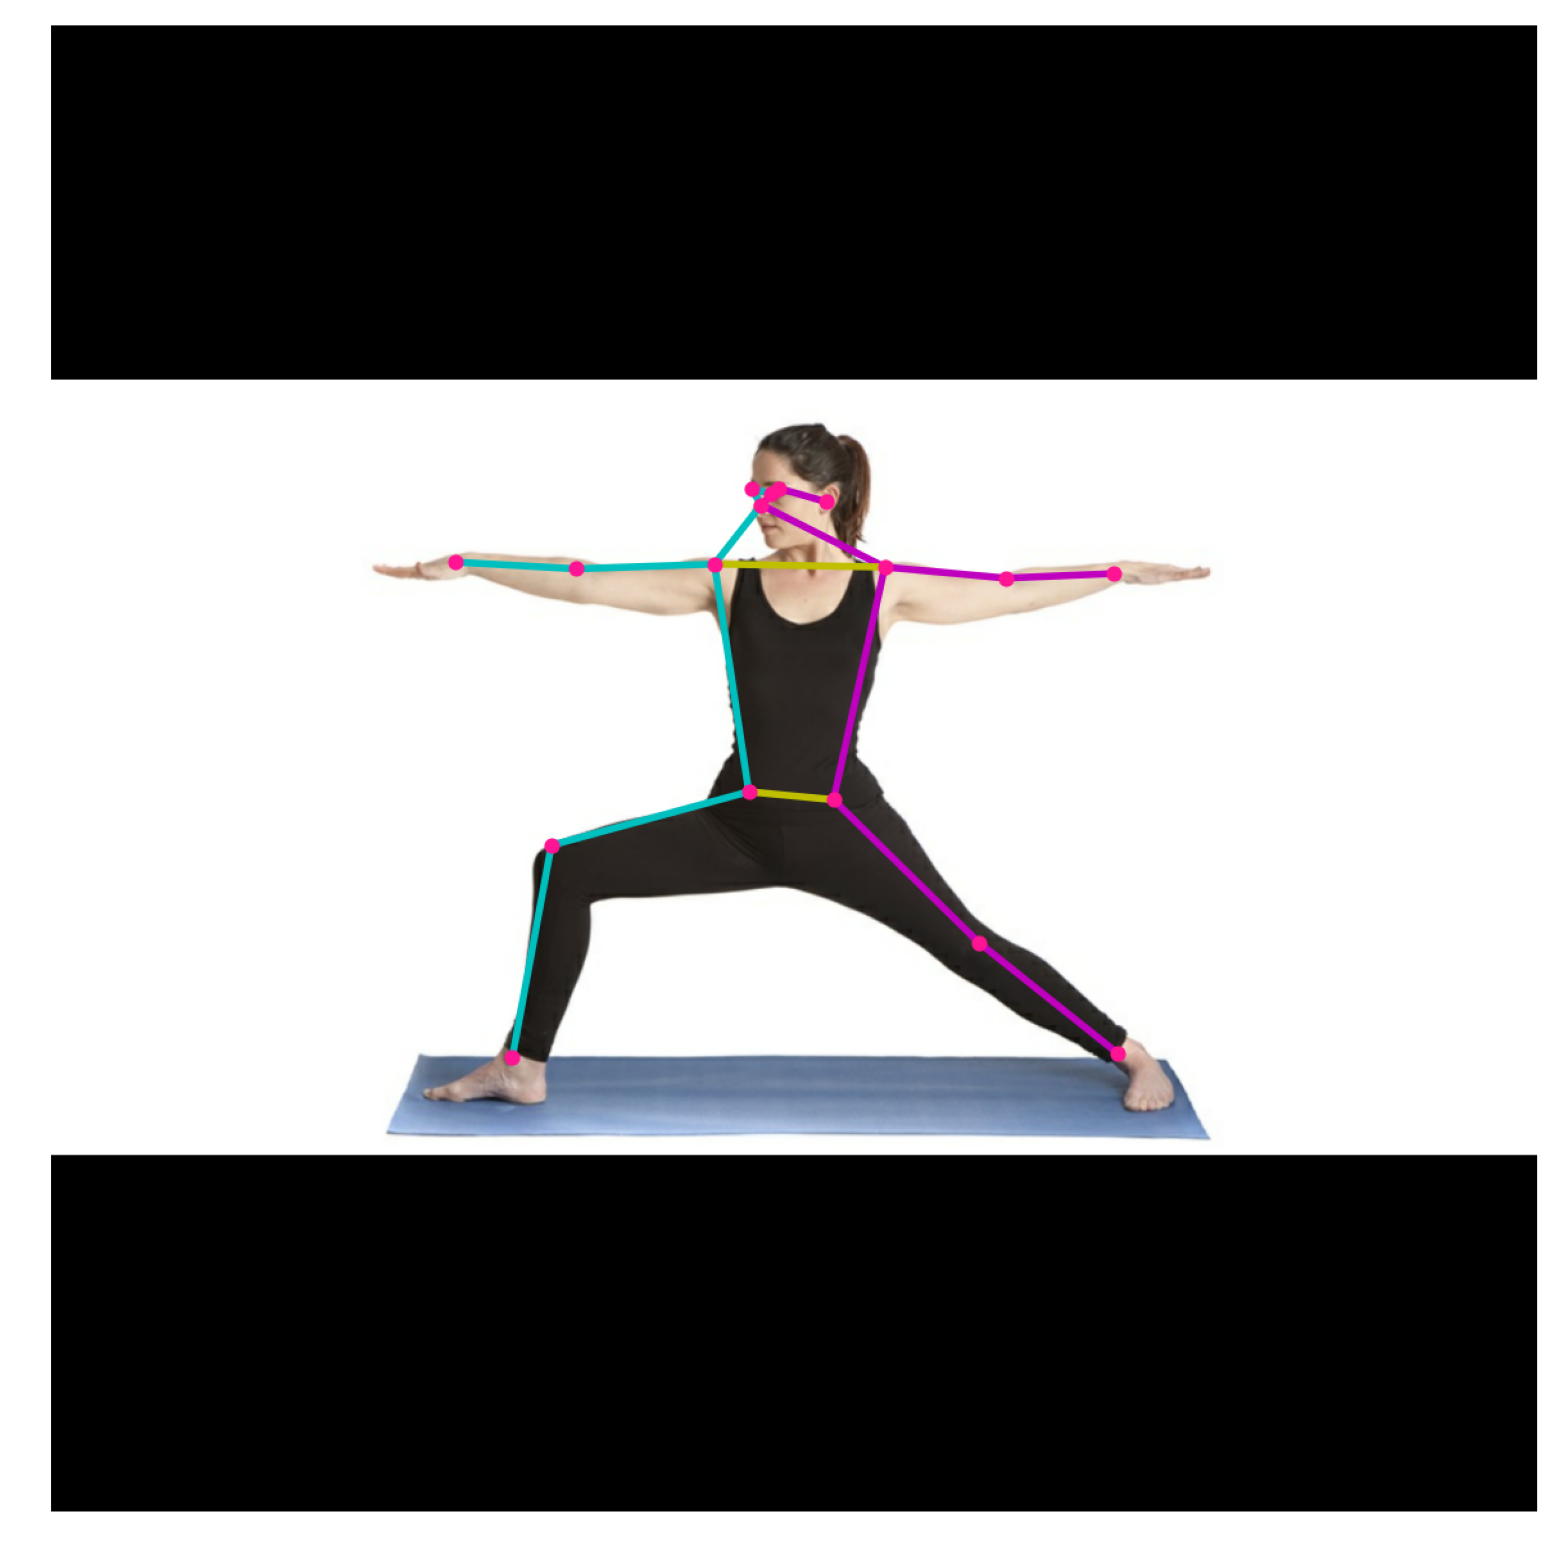

In [40]:
print('標準的{}姿勢為:'.format(pose_name))


if index == 0:
      example_dir = r'/googledrive/downdog.jpg'
elif index == 1:
      example_dir = r'/googledrive/goddess.jpg'
elif index == 2:
      example_dir = r'/googledrive/plank.jpg'
elif index == 3:
      example_dir = r'/googledrive/tree.jpg'
else:
      example_dir = r'/googledrive/warrior2.jpg'

# Load the input image.
image_path = example_dir
image = tf.io.read_file(image_path)
image = tf.image.decode_jpeg(image)
# Resize and pad the image to keep the aspect ratio and fit the expected size.
input_image = tf.expand_dims(image, axis=0)
input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

# Run model inference.
keypoint_with_scores = movenet(input_image)

# Visualize the predictions with image.
display_image = tf.expand_dims(image, axis=0)
display_image = tf.cast(tf.image.resize_with_pad(
    display_image, 1280, 1280), dtype=tf.int32)
output_overlay = draw_prediction_on_image(
    np.squeeze(display_image.numpy(), axis=0), keypoint_with_scores)

plt.figure(figsize=(20, 20))
plt.imshow(output_overlay)
_ = plt.axis('off')


In [41]:
example_keypoint=keypoint_with_scores

example_keypoint

array([[[[0.32222098, 0.47797117, 0.71210945],
         [0.31101996, 0.48955196, 0.6025762 ],
         [0.31109273, 0.47127676, 0.67535824],
         [0.32026213, 0.5220728 , 0.6947467 ],
         [0.31493133, 0.48501712, 0.6692912 ],
         [0.36409754, 0.5611834 , 0.6987383 ],
         [0.36210167, 0.4465843 , 0.7069454 ],
         [0.37155008, 0.6423482 , 0.49748737],
         [0.3653085 , 0.35349375, 0.7883629 ],
         [0.36850458, 0.7153239 , 0.82002544],
         [0.3607539 , 0.2717856 , 0.5299355 ],
         [0.5207549 , 0.5267073 , 0.70340014],
         [0.51536477, 0.46959847, 0.823354  ],
         [0.616837  , 0.6244428 , 0.84803706],
         [0.5514538 , 0.33670503, 0.81222063],
         [0.69123596, 0.71767664, 0.76667213],
         [0.69404906, 0.31045184, 0.78988737]]]], dtype=float32)

In [42]:
def calculate_angle(keypoint1, keypoint2):
    """計算兩個關鍵點之間的角度。

    Args:
        keypoint1: 第一個關鍵點的座標，格式為 (y, x, score)。
        keypoint2: 第二個關鍵點的座標，格式為 (y, x, score)。

    Returns:
        兩個關鍵點之間的角度（以度為單位）。
    """
    y1, x1, score1 = keypoint1
    y2, x2, score2 = keypoint2

    # 計算相對於第一個關鍵點的向量
    vector = np.array([x2 - x1, y2 - y1])

    # 使用 arctan2 計算角度，並將弧度轉換為度
    angle_rad = np.arctan2(vector[1], vector[0])
    angle_deg = np.degrees(angle_rad)

    return angle_deg


In [43]:
import pandas as pd

def calculate_angle_difference(start_keypoint, end_keypoint, target_keypoint, example_keypoint):

    target_start_keypoint = target_keypoint[0, 0, start_keypoint]
    target_end_keypoint = target_keypoint[0, 0, end_keypoint]

    example_start_keypoint = example_keypoint[0, 0, start_keypoint]
    example_end_keypoint = example_keypoint[0, 0, end_keypoint]


    target_angle = calculate_angle(target_start_keypoint, target_end_keypoint)
    example_angle = calculate_angle(example_start_keypoint, example_end_keypoint)
    angle_difference = target_angle - example_angle

    return angle_difference




KEYPOINT_DICT = {
     'nose':0,
     'left_eye':1,
     'right_eye':2,
     'left_ear':3,
     'right_ear':4,
     'left_shoulder':5,
     'right_shoulder':6,
     'left_elbow':7,
     'right_elbow':8,
     'left_wrist':9,
     'right_wrist':10,
     'left_hip':11,
     'right_hip':12,
     'left_knee':13,
     'right_knee':14,
     'left_ankle':15,
     'right_ankle':16
 }


data = {
    'start_keypoint': [9,7,3,5,11,13],
    'end_keypoint': [7,5,5,11,13,15],
    'angle difference': [0,0,0,0,0,0],
}

df = pd.DataFrame(data, index=['left_wrist to left_elbow','left_elbow to left_shoulder','left_ear to left_shoulder','left_shoulder to left_hip','left_hip to left_knee' ,'left_knee to left_ankle'])



df['angle difference'] = df.apply(lambda row: calculate_angle_difference(row['start_keypoint'], row['end_keypoint'], target_keypoint, example_keypoint), axis=1)
print('left side:')
print(df)


data = {
    'start_keypoint': [10,8,4,6,12,14],
    'end_keypoint': [8,6,6,12,14,16],
    'angle difference': [0,0,0,0,0,0],
}

df = pd.DataFrame(data, index=['right_wrist to right_elbow','right_elbow to right_shoulder','right_ear to right_shoulder','right_shoulder to right_hip','right_hip to right_knee' ,'right_knee to right_ankle'])



df['angle difference'] = df.apply(lambda row: calculate_angle_difference(row['start_keypoint'], row['end_keypoint'], target_keypoint, example_keypoint), axis=1)
print('\n')
print('right side:')
print(df)





left side:
                             start_keypoint  end_keypoint  angle difference
left_wrist to left_elbow                  9             7       -331.948792
left_elbow to left_shoulder               7             5         15.192474
left_ear to left_shoulder                 3             5         -4.412685
left_shoulder to left_hip                 5            11        -13.519119
left_hip to left_knee                    11            13          1.377876
left_knee to left_ankle                  13            15          0.572403


right side:
                               start_keypoint  end_keypoint  angle difference
right_wrist to right_elbow                 10             8        -19.415665
right_elbow to right_shoulder               8             6        -13.110435
right_ear to right_shoulder                 4             6         -6.132851
right_shoulder to right_hip                 6            12        -10.899956
right_hip to right_knee                    12        

In [45]:
print('目標對象在左手腕到左手肘的角度:',calculate_angle(target_keypoint[0,0,9], target_keypoint[0,0,7]))

print('標準姿勢在左手腕到左手肘的角度:',calculate_angle(example_keypoint[0,0,9], example_keypoint[0,0,7]))

print('目標對象與標準姿勢在左手腕到左手肘的角度差異:',calculate_angle(target_keypoint[0,0,9], target_keypoint[0,0,7])-calculate_angle(example_keypoint[0,0,9], example_keypoint[0,0,7]))

目標對象在左手腕到左手肘的角度: -154.33853
標準姿勢在左手腕到左手肘的角度: 177.61024
目標對象與標準姿勢在左手腕到左手肘的角度差異: -331.9488
